In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

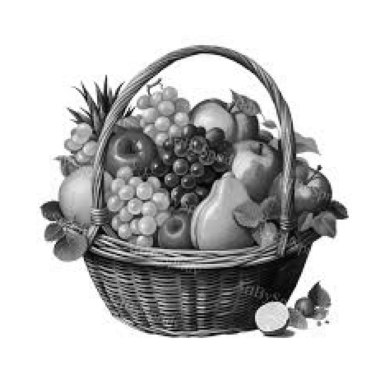

In [65]:
color_image = cv2.imread('image.jpeg')
image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

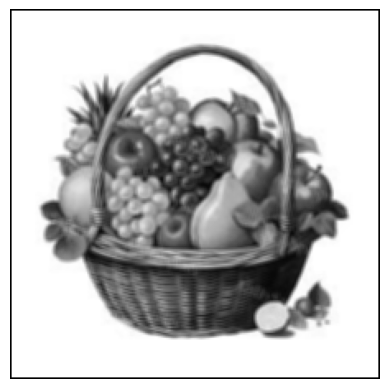

In [66]:
gaussian_mask = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9

def apply_mask(image, mask):
    filtered_image = np.zeros_like(image)
    height, width = image.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            region = image[i-1:i+2, j-1:j+2]
            value = np.sum(region * mask)
            filtered_image[i, j] = np.clip(value, 0, 255)
    return filtered_image

gaussian_image = apply_mask(image, gaussian_mask)
plt.imshow(gaussian_image, cmap="gray")
plt.axis("off")
plt.show()

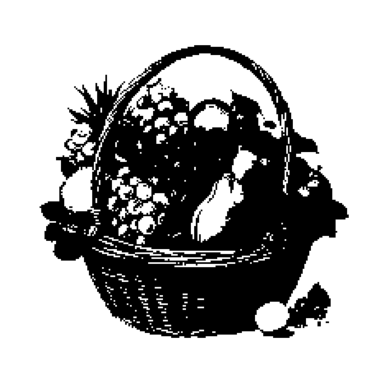

In [67]:
# Apply Thresholding
def apply_threshold(image, threshold):
    return np.where(image > threshold, 255, 0).astype(np.uint8)
 
def calc_histogram(image):
    hist = np.zeros(256, dtype=int)
    for pixel_value in image.ravel():
        hist[pixel_value] += 1
    return hist
 
def calc_cumulative_sum(hist):
    cumulative_sum = np.cumsum(hist)
    return cumulative_sum
 
def calc_cumulative_mean(hist, cumulative_sum):
    cumulative_mean = np.cumsum(hist * np.arange(256))
    return cumulative_mean
 
def otsu_threshold(image):
    hist = calc_histogram(image)
    total_pixels = image.size
    cumulative_sum = calc_cumulative_sum(hist)
    cumulative_mean = calc_cumulative_mean(hist, cumulative_sum)
 
    global_mean = cumulative_mean[-1] / total_pixels
 
    max_between_class_variance = 0
    optimal_threshold = 0
 
    for t in range(1, 256):
        weight_background = cumulative_sum[t] / total_pixels
        mean_background = cumulative_mean[t] / cumulative_sum[t] if cumulative_sum[t] != 0 else 0
 
        weight_foreground = (total_pixels - cumulative_sum[t]) / total_pixels
        mean_foreground = (cumulative_mean[-1] - cumulative_mean[t]) / (total_pixels - cumulative_sum[t]) if (total_pixels - cumulative_sum[t]) != 0 else 0
 
        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
 
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            optimal_threshold = t
 
    return optimal_threshold
 
otsu_threshold_value = otsu_threshold(image)
otsu_thresholded_image = apply_threshold(image, otsu_threshold_value)
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.axis("off")
plt.show()

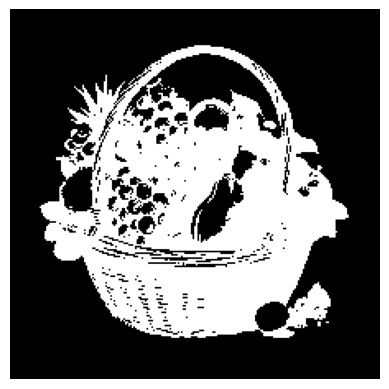

In [68]:
ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.axis("off")
plt.show()

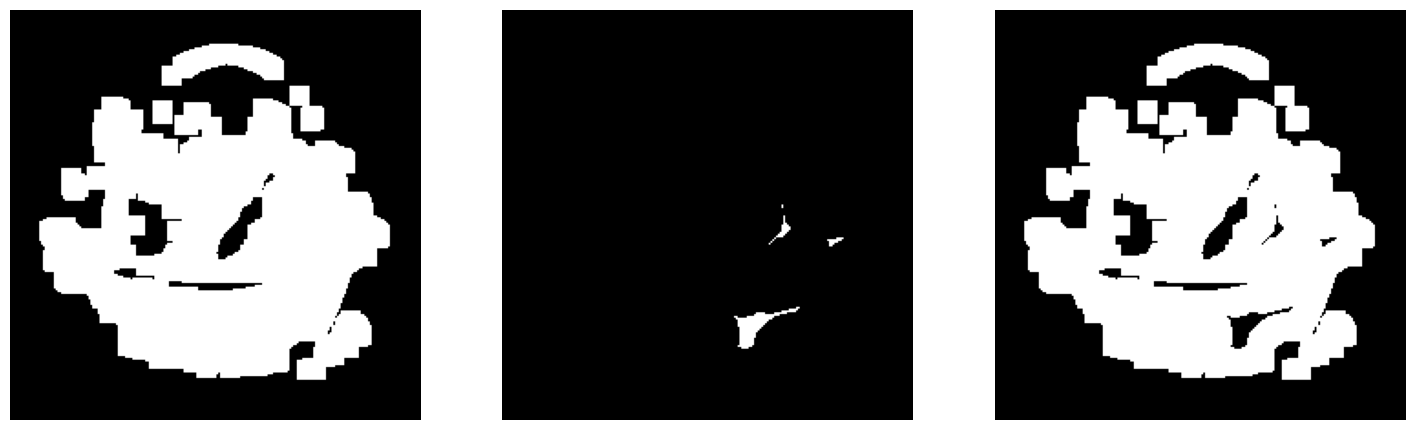

In [69]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = np.abs(sure_bg - sure_fg)

plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
plt.imshow(sure_bg, cmap='gray')
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(sure_fg, cmap='gray')
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(unknown, cmap='gray')
plt.axis("off")
plt.show()

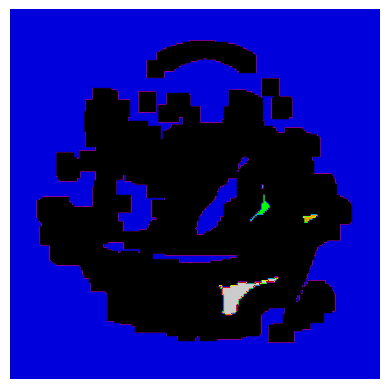

In [70]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='nipy_spectral')
plt.axis("off")
plt.show()

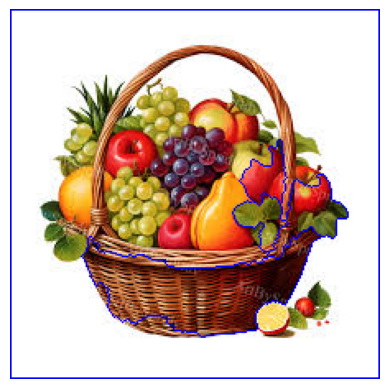

In [76]:
markers = cv2.watershed(color_image,markers)
color_image[markers == -1] = [255,0,0]

new_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
plt.imshow(new_image) 
plt.axis("off")
plt.show()
